# Nursery Scenario

In [1]:
from NN import *
from LTL import *


from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np

Number of Omega-automaton states (including the trap state): 55


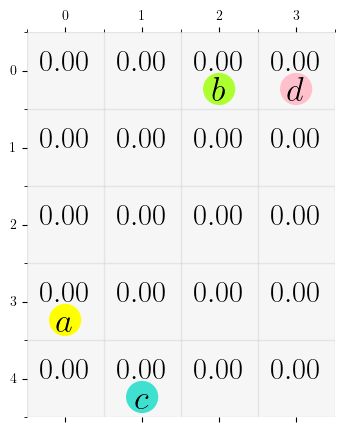

In [2]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
[(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
p=0.8
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [3]:
csrl.shape, csrl.ch_states[(0,0,0,0)].shape, max_rew

((1, 55, 5, 4, 59), (5, 4, 55), 0.01)

In [4]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 55)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     7072        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [6]:
t = "[] ( (~d) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ ((~b /\ >b /\ ~>>b)->(~a % c)) )"

full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates={'a':[12], 'b':[2], 'c':[17], 'd':[3]}

### proof of satifying trajectory ###
tra = [17,13,9,5,1,2,6,10,14,18,17]
print(len(tra), check_LTL(LTL_formula, tra, predicates))
#######

11 [True, True, True, True, True, True, True, True, True]


In [7]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [26]:

num_epochs = 20
training = True
T = [100]
K = 3
search_depth = 30

success_rates = []
for i in T:
    wins = 0
    for epoch in range(num_epochs):

        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, search_depth=search_depth, verbose=4, start=(4,1), T=i, K=3)

        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1

        if training:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)

    success_rates.append(wins/num_epochs)
    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)

FAIL: states (if in acc) [None, None, None, None, None, None, None, None, None, None, None]
trajectory: [17, 17, 18, 19, 19, 15, 14, 10, 6, 2, 3]
FAIL: states (if in acc) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
trajectory: [17, 17, 18, 19, 15, 14, 10, 6, 7, 6, 2, 2, 6, 10, 9, 8, 12, 13, 9, 10, 11, 7, 3]
FAIL: states (if in acc) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True, None]
trajectory: [17, 17, 18, 19, 15, 14, 10, 6, 2, 2, 6, 10, 9, 13, 12, 8, 9, 10, 9, 10, 14, 10, 9, 5, 1, 2, 3]
trajectory: [17, 17, 18, 19, 15, 14, 10, 6, 2, 2, 6, 10, 9, 13, 12, 8, 9, 10, 9, 10, 14, 10, 9, 5, 1, 2, 3]
action_history: [1, 2, 2, 0, 3, 0, 0, 0, 0, 1, 1, 3, 1, 3, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0]
state history: [(0, 0, 4, 1), (0, 16, 4, 1), (0, 16, 4, 2), (0, 49, 4, 3), (0, 49, 3, 3), (0, 49,

In [10]:
N[(0,0,4,1)], better_policy[0]

(array([ 146., 2259., 1038.,   22.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([0.04213564, 0.65194805, 0.2995671 , 0.00634921, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.       

In [37]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T[-1]-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [12]:
csrl.reward[0,3,4,1]

0.0

In [13]:
Q = (N/N.max())

In [7]:
Q=csrl.q_learning(T=100,K=100000)

In [8]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

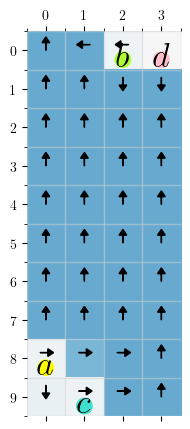

In [9]:
policy=np.argmax(Q,axis=4)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy,iq=(0,0))

In [9]:
episode=csrl.simulate(policy,start=(0,0),T=1000)

TypeError: ControlSynthesis.simulate() missing 2 required positional arguments: 'LTL_formula' and 'predicates'

In [12]:
episode, rew =csrl.simulate(policy, LTL_formula, predicates, start=(9,1),T=100,plot=True)
elements, counts = np.unique(np.array(episode)[:,1], return_counts=True)
sorted(zip(elements,counts),key=lambda x:-x[1])

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

[(57, 98), (0, 1), (16, 1), (49, 1)]

In [22]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(9,1),T=100, runs=100, verbose=0)

Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


In [ ]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

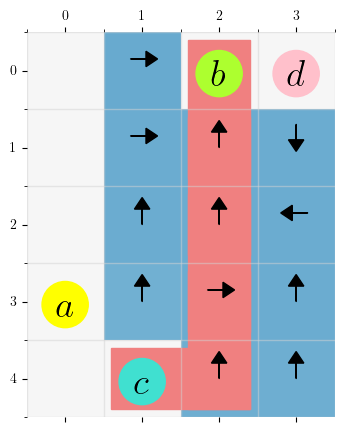

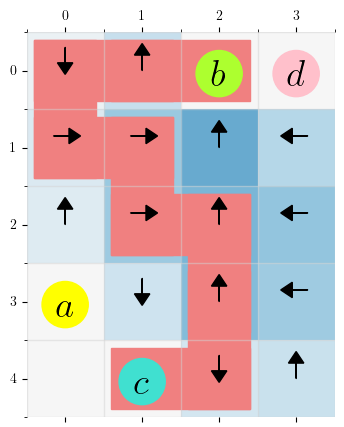

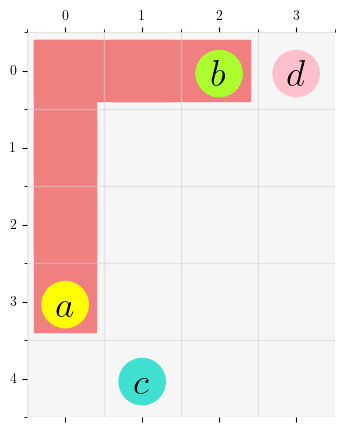

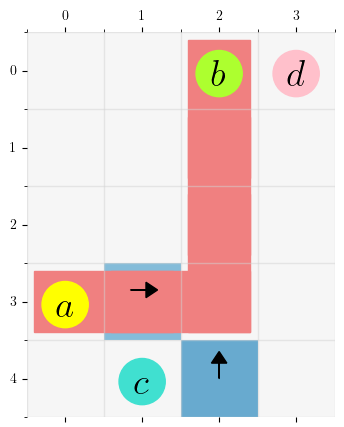

In [26]:
# Plot the important parts of the policy

policy=np.argmax(Q,axis=4)

hidden = [(0,0),(1,0),(2,0),(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (4,1) : 'r',
    (4,2) : 'lu',
    (3,2) : 'du',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,2),save='nursery_scenario_policy_cb.pdf',path=path,hidden=hidden)


hidden = [(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ur',
    (1,1) : 'ld',
    (2,1) : 'ur',
    (2,2) : 'ld',
    (3,2) : 'ud',
    (4,2) : 'ul',
    (4,1) : 'r'
}
csrl.plot(value,policy,iq=(0,41),save='nursery_scenario_policy_bc.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(4,1),(4,2),(4,3),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ud',
    (2,0) : 'ud',
    (3,0) : 'u'
}
csrl.plot(value,policy,iq=(0,12),save='nursery_scenario_policy_ba.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(0,2),(0,3),(4,1)]
path = {
    (3,0) : 'r',
    (3,1) : 'lr',
    (3,2) : 'lu',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,9),save='nursery_scenario_policy_ab.pdf',hidden=hidden,path=path)

In [14]:
# Save the animation
episode=csrl.simulate(policy,start=(4,1),T=100, animation='test')

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…